In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os 
import json
import pandas as pd

/Users/amelie/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [4]:
dir_path='Data/Descriptions/'
description=[]
for fname in os.listdir(dir_path):
    description.append(json.load(open(dir_path+fname, 'r')))

df = pd.DataFrame.from_records(description)
df =  df.merge(pd.json_normalize(df.meta, sep="_"), left_index=True, right_index=True)
df = df.drop(columns=['creator', 'dataset', 'meta', 'notes'])
img_size = (df.acquisition_pixelsX.min(),df.acquisition_pixelsY.min())
data_set = tf.keras.preprocessing.image_dataset_from_directory(
    'Data/Images/',
    label_mode='binary',
    image_size=img_size)

Found 1000 files belonging to 2 classes.


2021-11-10 13:38:11.157408: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
#TODO filter data set for wrong images (wrong name, file type etc.)

In [6]:
data_set.take(1)

<TakeDataset shapes: ((None, 576, 540, 3), (None, 1)), types: (tf.float32, tf.float32)>

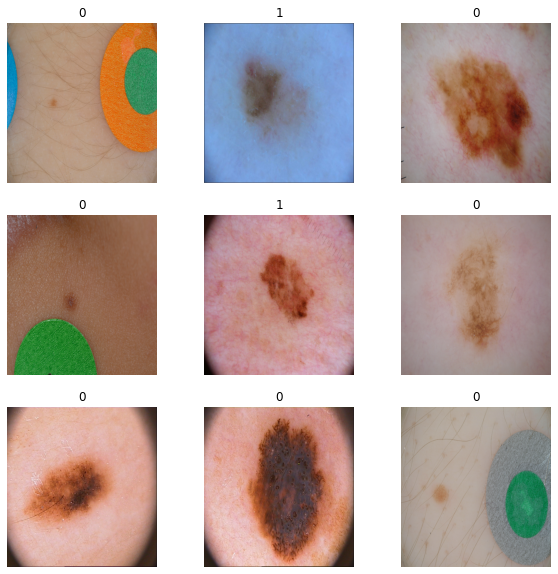

In [7]:
#A: visualise data, I'm not sure I understand how it knows which one is cancerous, not even sure if that's correct
#A: aren't the pictures deformed to fit a square?
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

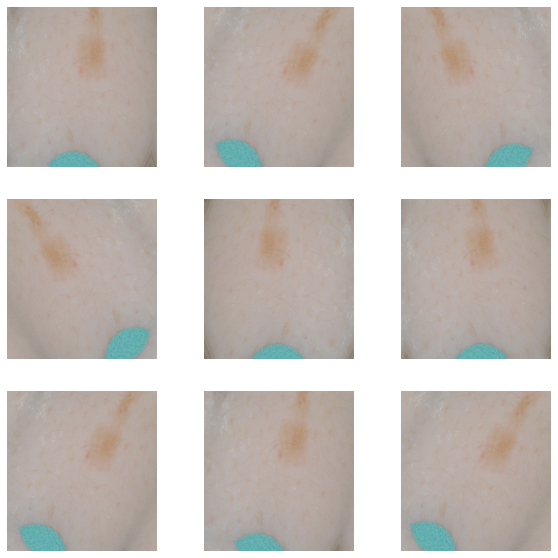

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in data_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=img_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
epochs = 3

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    data_set, epochs=epochs, callbacks=callbacks, validation_data=data_set,
)

Epoch 1/3
32/32 [==============================] - ETA: 0s - loss: 0.4637 - accuracy: 0.7900  

/Users/amelie/.pyenv/versions/3.9.7/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


32/32 [==============================] - 4339s 135s/step - loss: 0.4637 - accuracy: 0.7900 - val_loss: 0.5835 - val_accuracy: 0.8410
Epoch 2/3
15/32 [=============>................] - ETA: 37:00 - loss: 0.3704 - accuracy: 0.8604

In [17]:
img = keras.preprocessing.image.load_img(
    "Data/Images/benign/ISIC_0000000.jpeg", target_size=img_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent benign and %.2f percent malignant."
    % (100 * (1 - score), 100 * score)
)

This image is 49.97 percent benign and 50.03 percent malignant.
